In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras import Sequential
import numpy as np
from tensorflow.keras.layers import Dense, Input, MaxPooling2D, Dropout, Flatten
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
img_height = 400
img_width = 400
batch_size = 32
epochs = 30

In [3]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory('data/train',
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

valid_generator = datagen.flow_from_directory('data/test',
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')


Found 7631 images belonging to 2 classes.
Found 1907 images belonging to 2 classes.


In [4]:
# for image_batch, labels_batch in train_generator:
#     print(image_batch.shape)
#     print(labels_batch.shape)
#     break

In [5]:
pretrained_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(img_height, img_width, 3),
    pooling=None,
    classes=1000
)

pretrained_model.trainable=False

model=Sequential()

model = tf.keras.Sequential()

for layer in pretrained_model.layers[:-1]:
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = False

model.add(tf.keras.layers.Conv2D(filters=2048, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(2, activation='softmax'))


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[metrics.AUC(), 'accuracy'])


In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 400, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 400, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 200, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 200, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 100, 128)     0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 100, 100, 256)    

In [7]:
history = model.fit(
  train_generator,
  steps_per_epoch=train_generator.samples//batch_size,
  validation_data=valid_generator,
  validation_steps=valid_generator.samples//batch_size,
  epochs=epochs
)

Epoch 1/30
238/238 [==============================] - 195s 820ms/step - loss: 0.4824 - auc: 0.8621 - accuracy: 0.7844 - val_loss: 0.4137 - val_auc: 0.8924 - val_accuracy: 0.8008
Epoch 2/30
238/238 [==============================] - 195s 819ms/step - loss: 0.3053 - auc: 0.9441 - accuracy: 0.8760 - val_loss: 0.2835 - val_auc: 0.9511 - val_accuracy: 0.8766
Epoch 3/30
238/238 [==============================] - 194s 814ms/step - loss: 0.2682 - auc: 0.9565 - accuracy: 0.8938 - val_loss: 0.2025 - val_auc: 0.9757 - val_accuracy: 0.9306
Epoch 4/30
238/238 [==============================] - 195s 821ms/step - loss: 0.2311 - auc: 0.9676 - accuracy: 0.9147 - val_loss: 0.1854 - val_auc: 0.9784 - val_accuracy: 0.9370
Epoch 5/30
238/238 [==============================] - 195s 820ms/step - loss: 0.2108 - auc: 0.9728 - accuracy: 0.9256 - val_loss: 0.1665 - val_auc: 0.9830 - val_accuracy: 0.9428
Epoch 6/30
238/238 [==============================] - 195s 819ms/step - loss: 0.1982 - auc: 0.9756 - accuracy:

KeyboardInterrupt: 

In [263]:
index = 39

In [264]:
get_output = tf.keras.backend.function([model.layers[0].input],
                                       [model.layers[-3].output, model.layers[-1].output])
[conv_outputs, predictions] = get_output(valid_generator[index][0])
class_weights = model.layers[-1].get_weights()[0]

In [265]:
output = []
for num, idx in enumerate(np.argmax(predictions,axis=1)):
    cam = tf.matmul(np.expand_dims(class_weights[:,idx],axis = 0),
                    np.transpose(np.reshape(conv_outputs[num],(25*25,2048))))
    cam = tf.keras.backend.eval(cam)
    output.append(cam)

In [266]:
import cv2

heatmap = np.reshape(output[0][0], (25, 25))
heatmap = heatmap / (np.max(heatmap) - np.min(heatmap)) * 255.9
heatmap = -heatmap + 256
heatmap = np.uint8(heatmap - np.min(heatmap))
heatmap = cv2.resize(heatmap, (img_height, img_width))
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

In [267]:
origin_img = valid_generator[index][0][0]
origin_img = origin_img / (np.max(origin_img) - np.min(origin_img)) * 255.9
origin_img = np.uint8(origin_img - np.min(origin_img))

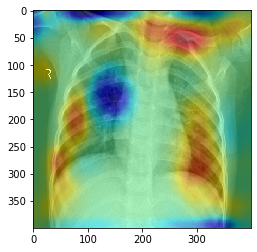

In [268]:
a = 0.5
dst = cv2.addWeighted(origin_img, a, heatmap, 1 - a, 0)
plt.imshow(dst)

In [269]:
prediction = model.predict(valid_generator[index][0])
np.argmax(prediction[0])

1